# Deep Deterministic Policy Gradient

In [4]:
!pip install gymnasium
!pip install torch

     ---------------------------------------- 0.0/172.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/172.4 MB 1.1 MB/s eta 0:02:39
     ---------------------------------------- 0.2/172.4 MB 2.5 MB/s eta 0:01:10
     ---------------------------------------- 0.4/172.4 MB 3.0 MB/s eta 0:00:58
     ---------------------------------------- 0.5/172.4 MB 2.7 MB/s eta 0:01:05
     ---------------------------------------- 0.7/172.4 MB 2.8 MB/s eta 0:01:01
     ---------------------------------------- 0.7/172.4 MB 3.0 MB/s eta 0:00:58
     ---------------------------------------- 0.8/172.4 MB 2.7 MB/s eta 0:01:05
     ---------------------------------------- 0.9/172.4 MB 2.7 MB/s eta 0:01:04
     ---------------------------------------- 0.9/172.4 MB 2.3 MB/s eta 0:01:15
     ---------------------------------------- 1.1/172.4 MB 2.4 MB/s eta 0:01:13
     ---------------------------------------- 1.3/172.4 MB 2.4 MB/s eta 0:01:10
     ---------------------------------------- 1

In [3]:
import copy
import random
import collections

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from gymnasium.experimental.wrappers import RecordVideoV0 as RecordVideo


ModuleNotFoundError: No module named 'torch'

# Environment

In [4]:
# continuous environment
env = gym.make('HalfCheetah-v4', render_mode="rgb_array")
env = RecordVideo(env, "./videos", disable_logger=False)
env

<RecordVideoV0<TimeLimit<OrderEnforcing<PassiveEnvChecker<HalfCheetahEnv<HalfCheetah-v4>>>>>>

# Hyperparameters

In [5]:
AC_config = OmegaConf.create({
    # RL parameter
    'gamma': 0.99,
    
    # replay memory
    'buffer_limit': int(1e5),
    'batch_size': 32,
    
    # neural network parameters
    'device': 'cpu',
    'hidden_dim': 64,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]), # cannot use .n because not actions are continuous!
    
    # learning parameters
    'lr_actor': 0.0005,
    'lr_critic': 0.001,
    'tau': 0.005,
})

# Special functions
- Replay Buffer
- Ornstein_Uhlenbeck_Noise: add noise to the action (=output of Actor network) $\rightarrow$ exploration $\uparrow$
- soft_update: prevent the drastic change of neural network

In [6]:
# replay buffer
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.buffer = collections.deque(maxlen=self.config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, next_s_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            next_s_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.Tensor(s_lst), torch.Tensor(a_lst), torch.Tensor(r_lst), torch.Tensor(next_s_lst), torch.Tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)
    
    
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x
    
# moving average over the neural network parameters
def soft_update(net, net_target, tau):
    # for each parameters,
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        # mix the target and current parameters with the ratio of (1 - tau) : (tau)
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)
    

# Main Structure: Actor-Critic
- with target networks (recall DQN)
- update method has changed:


In [10]:
class ActorCritic(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.data = []
        self.config = config
        
        # create replay buffer
        self.memory = ReplayBuffer(self.config)
        # set exploration noise
        self.action_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim))

        # actor: policy network
        self.actor = nn.Sequential(
            nn.Linear(self.config.state_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, self.config.action_dim),
            nn.Tanh(), # continuous action, bound output to [-1, 1]
        )
        # critic: Q(s, a) network
        self.critic = nn.Sequential(
            nn.Linear(self.config.state_dim + self.config.action_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, self.config.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.config.hidden_dim, 1),
        )
        # we need target networks:
        self.actor_target, self.critic_target = copy.deepcopy(self.actor), copy.deepcopy(self.critic)
        
        # load them to gpu (if available)
        self.to(self.config.device)
        
        # we use different learning rates for actor and critic networks
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=self.config.lr_actor)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.config.lr_critic)
        
        # parameter for soft update
        self.tau = self.config.tau
        
    # training function
    def update(self):
        # randomly sample from replay buffer
        states, actions, rewards, next_states, dones = self.memory.sample(self.config.batch_size)
        
        # compute target q values -- we concatenate state & action to make (s, a) 
        # they have shape of (Batch size x state_dim) & (Batch size x action_dim).
        # We need to make it (Batch size x state_dim + action_dim), meaning that the concatenation must happen in the last dimension,
        # i.e. dim=-1
        target_q_values = rewards + self.config.gamma * self.critic_target(
            torch.cat([next_states, self.actor_target(next_states)], dim=-1)
        ) * dones
        
        # compute q loss
        critic_loss = F.smooth_l1_loss(self.critic(torch.cat([states, actions], dim=-1)), target_q_values.detach())
        # compute gradient & update
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        actor_loss = -self.critic(torch.cat([states, self.actor(states)], dim=-1)).mean() # That's all for the policy loss.
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()
        
        # soft update
        soft_update(self.actor, self.actor_target, self.tau)
        soft_update(self.critic, self.critic_target, self.tau)
        

# Learn

In [11]:
num_epis, epi_rews = 5000, []
agent = ActorCritic(AC_config)

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    
    while not (terminated or truncated):
        # get action from actor network
        action = agent.actor(torch.Tensor(list(state))).detach().numpy()
        # add noise for better exploration
        action = action + agent.action_noise()

        next_state, reward, terminated, truncated, _ = env.step(action)

        # save transition to replay buffer
        agent.memory.put((state, action, reward, next_state, terminated or truncated))

        # state transition
        state = next_state

        # record reward
        epi_rew += reward
        
    # enough memory
    if agent.memory.size() > 5000:
        # off-line training
        for i in range(10):
            agent.update()
            
    epi_rews += [epi_rew]
env.close()

 13%|█▎        | 638/5000 [02:15<15:51,  4.59it/s]

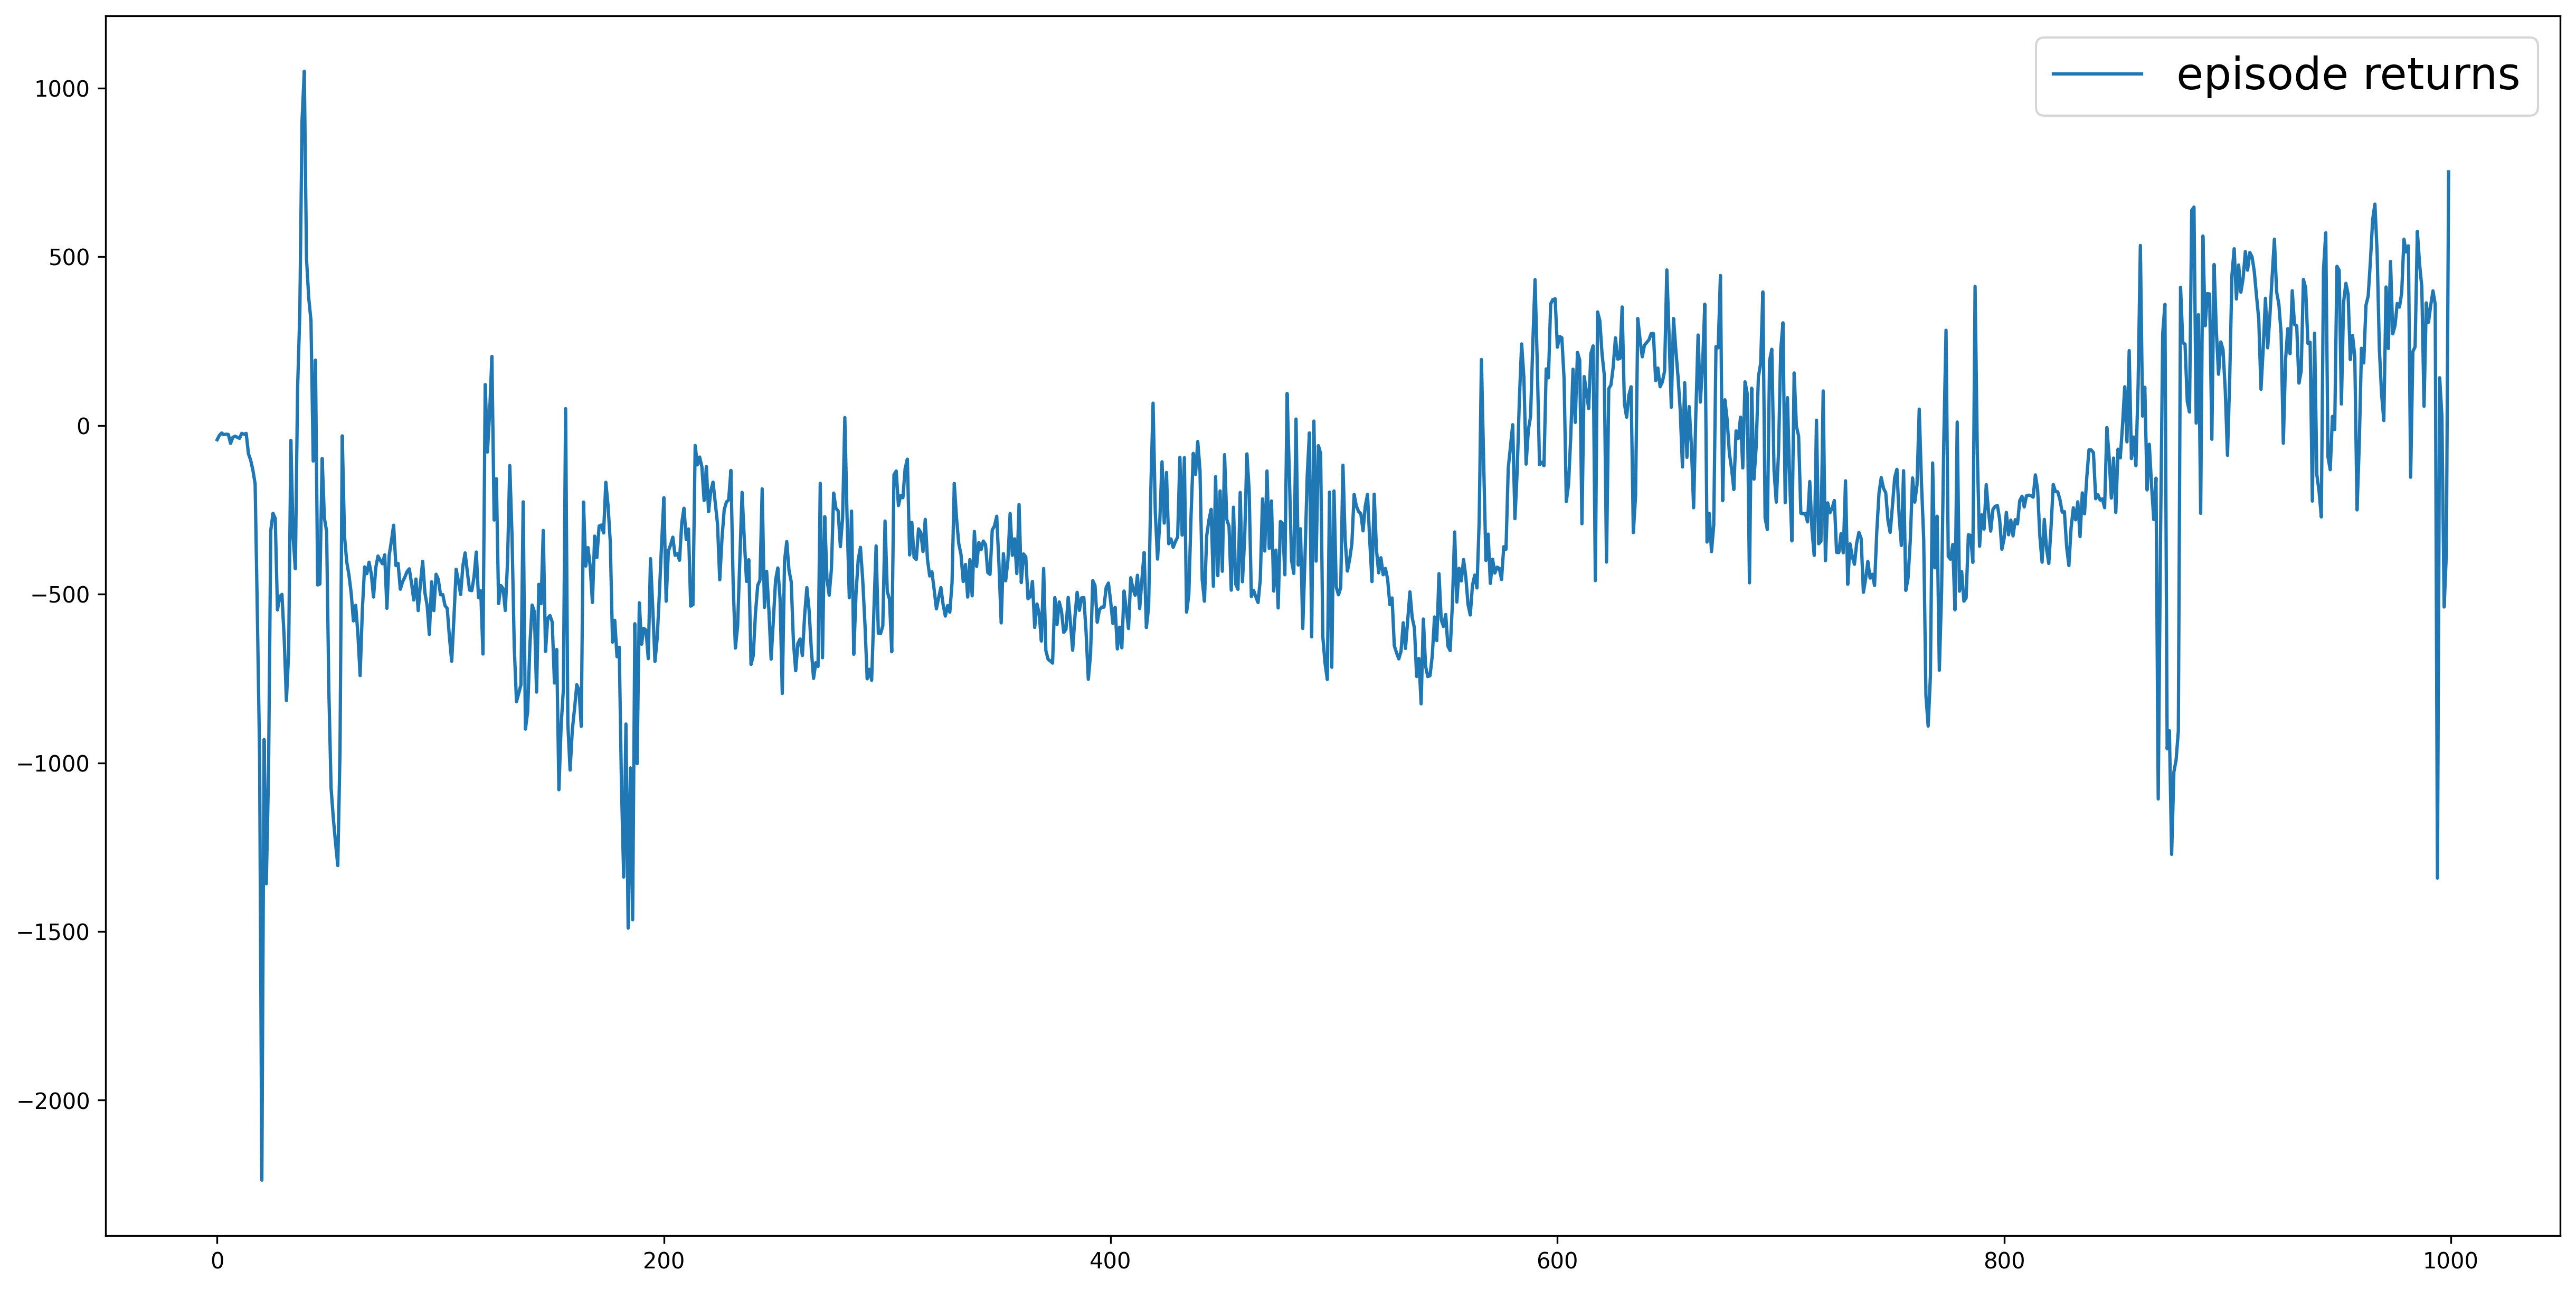

In [9]:
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(epi_rews, label='episode returns')
plt.legend(fontsize=20)
plt.show()
plt.close()

# Check the video!